## Importing Libraries

In [117]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import plotly.express as px
import matplotlib.pyplot as plt
from keras.models import Sequential
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense
from statsmodels.tsa.holtwinters import ExponentialSmoothing

## Loading the data

In [99]:
def loadData ():
    csvFiles = [os.path.join("datasets", filename) for filename in os.listdir("datasets") if filename.endswith(('.csv'))]
    data = []
    for file in csvFiles:
        frame = pd.read_csv(file).drop(['index'], axis=1)
        if file == 'datasets\Mental health Depression disorder Data.csv' :
            frame = frame.loc[:6467]
            for column in frame.columns:
                if column != 'Entity' and column != 'Code':
                    frame[column] = frame[column].astype(float)
            frame['Year'] = frame['Year'].astype(int)
        if 'Code' in frame.columns:
            frame.drop(columns='Code',axis=1,inplace=True)
        if 'Country' in frame.columns:
            frame.rename(columns={'Country': 'Entity'}, inplace=True)
        data.append(frame)
    return data

In [100]:
data = loadData()
data = yearlyAverage(data)

C:\Users\dell\AppData\Local\Temp\ipykernel_1996\3597135414.py:5: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  frame = pd.read_csv(file).drop(['index'], axis=1)


In [101]:
def globalAverage(data, frame, disorder):
    averages = []
    for year in data['Year'].unique():
        averages.append(data[data['Year'] == year][disorder].mean())
    frame[disorder] = averages
    return frame

In [102]:
def yearlyAverage(data):
    frames = []   
    for dataframe in data:
        frame = pd.DataFrame()
        frame['Year'] = dataframe['Year'].unique()
        frame['Year'] = frame['Year'].astype(int)
        for feature in dataframe.columns[2:]:
            frame = globalAverage(dataframe,frame, feature)
        frames.append(frame)
    return frames

## Plotting the data

In [103]:
def plotting(df, sort_by, color_by, dpi=200):
    df.sort_values(by=sort_by, inplace=True)
    plt.figure(dpi=dpi) 
    fig = px.bar(df, x=sort_by, y="Entity", orientation='h', color=color_by)
    fig.show()

In [104]:
def plotHistogram(df, column, title, xlabel, ylabel, figsize=(10, 6), kde=True):
    plt.figure(figsize=figsize)
    sns.histplot(df[column], kde=kde)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# Example usage
# plot_histogram(df, 'Schizophrenia disorders (share of population) - Sex: Both - Age: Age-standardized', 
#                'Distribution of Schizophrenia Disorder Prevalence', 'Prevalence (Age-standardized)', 'Frequency')


In [105]:

def plotLosses(trainLosses, valLosses, title='Training and Validation Losses', xlabel='Epoch', ylabel='Loss'):

    plt.plot(trainLosses, label='Train Loss')
    plt.plot(valLosses, label='Val Loss')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

# Example usage
# plot_losses(train_losses, val_losses)


### Model Architecture

In [106]:
# Function to plot predicted vs actual data
def plotPredictionsVSActual(xTest, yTest, outputs, interval=(0, 39)):

    i = random.randint(*interval)

    # Extend the last point in the test sequence with the predicted and actual outcome
    predicted = np.append(xTest[i, :, 0], outputs[i])
    actual = np.append(xTest[i, :, 0], yTest[i])

    # Time points for plotting
    x = np.linspace(0, len(predicted) - 1, len(predicted))

    # Plotting the series
    plt.figure(figsize=(10, 6))
    plt.plot(x[:-1], actual[:-1], 'r-', label='Actual (History)')
    plt.plot(x[-1:], actual[-1:], 'ro', label='Actual (Latest)', markersize=10)
    plt.plot(x[:-1], predicted[:-1], 'b-', label='Predicted (History)')
    plt.plot(x[-1:], predicted[-1:], 'bo', label='Predicted (Latest)', markersize=10)

    # Identify and highlight overlapping regions in the prediction
    overlap = np.logical_and(predicted > 0, actual > 0)
    plt.plot(x[overlap], actual[overlap], 'k', label='Overlap')

    # Adding plot decorations
    plt.title('Depression Prediction and Actual Values for a Random Index')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Example usage (assuming xTest, yTest, and outputs are defined properly)
# plot_prediction_vs_actual(xTest, yTest, outputs)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Year                         30 non-null     int32  
 1   Schizophrenia disorders (%)  30 non-null     float64
 2   Depressive disorders (%)     30 non-null     float64
 3   Anxiety disorders (%)        30 non-null     float64
 4   Bipolar disorders (%)        30 non-null     float64
 5   Eating disorders (%)         30 non-null     float64
dtypes: float64(5), int32(1)
memory usage: 1.4 KB


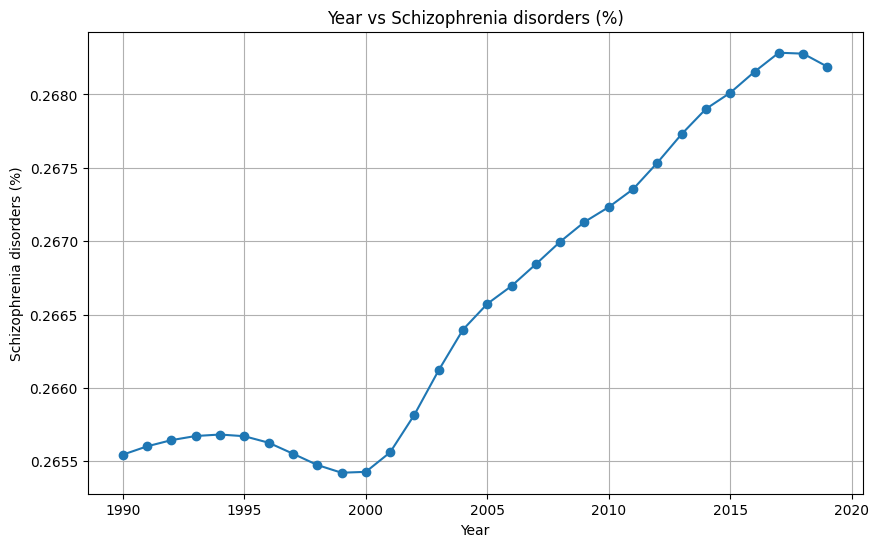

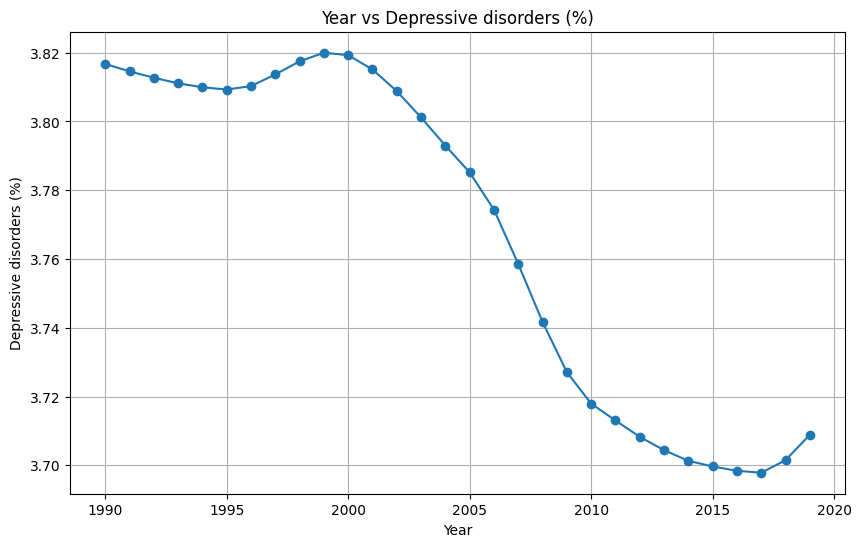

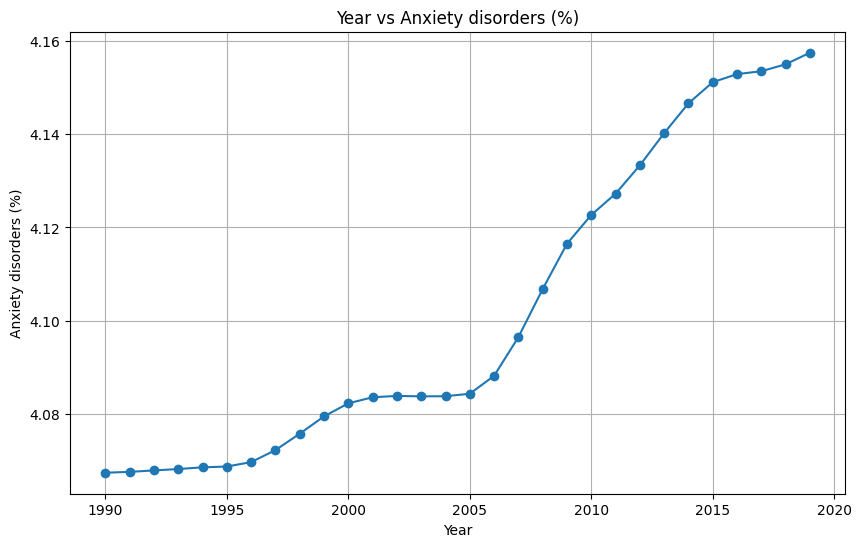

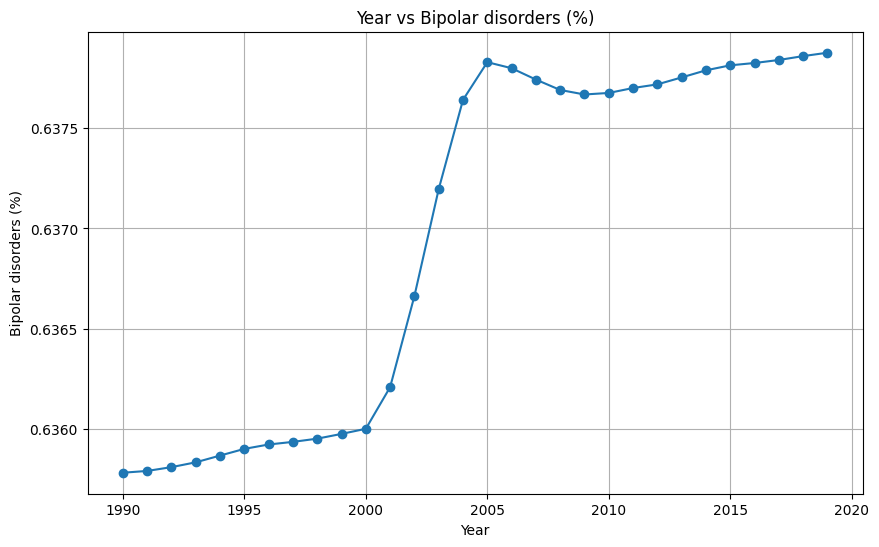

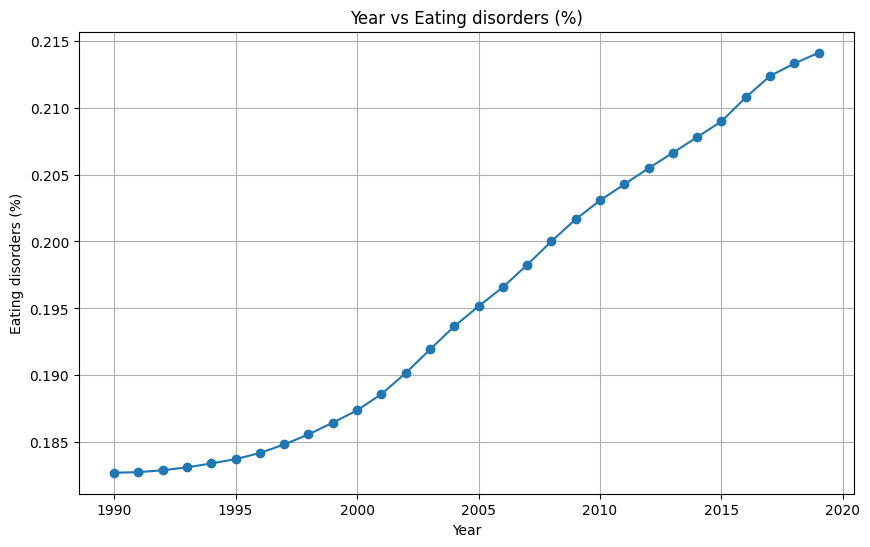

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year                       28 non-null     int32  
 1   Schizophrenia (%)          28 non-null     float64
 2   Bipolar disorder (%)       28 non-null     float64
 3   Eating disorders (%)       28 non-null     float64
 4   Anxiety disorders (%)      28 non-null     float64
 5   Drug use disorders (%)     28 non-null     float64
 6   Depression (%)             28 non-null     float64
 7   Alcohol use disorders (%)  28 non-null     float64
dtypes: float64(7), int32(1)
memory usage: 1.8 KB


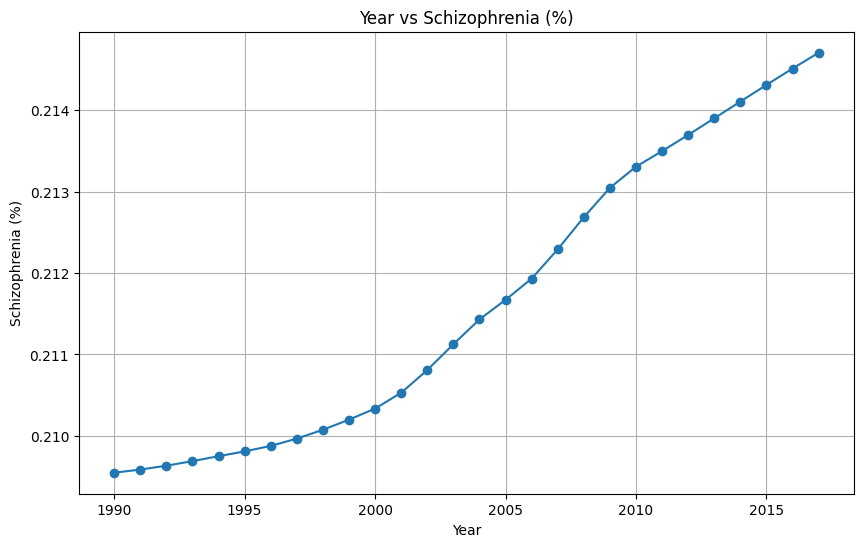

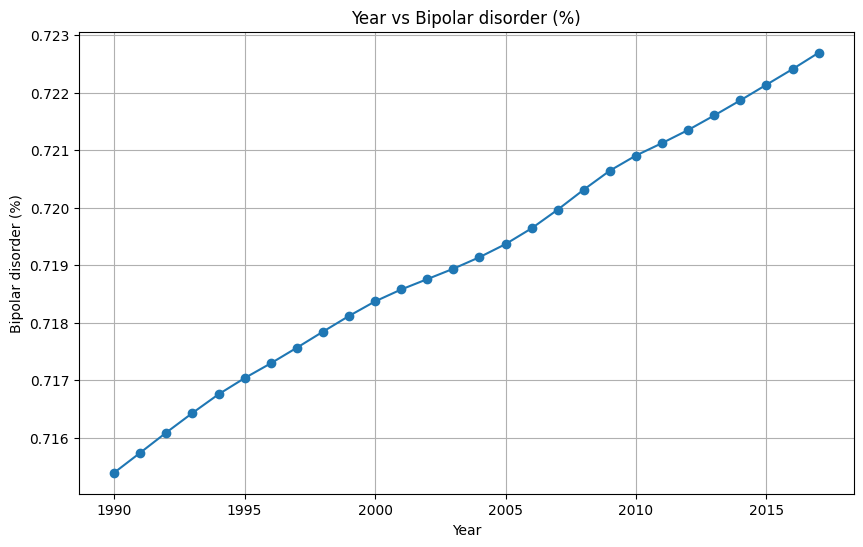

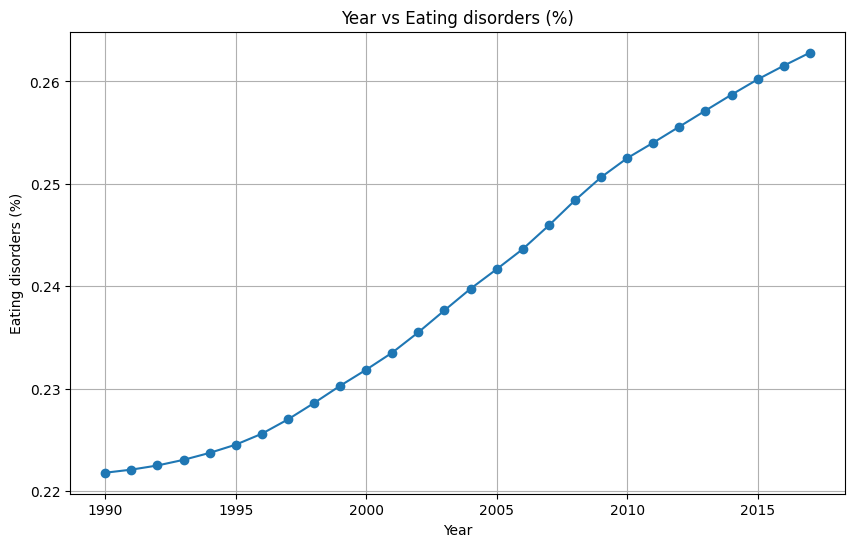

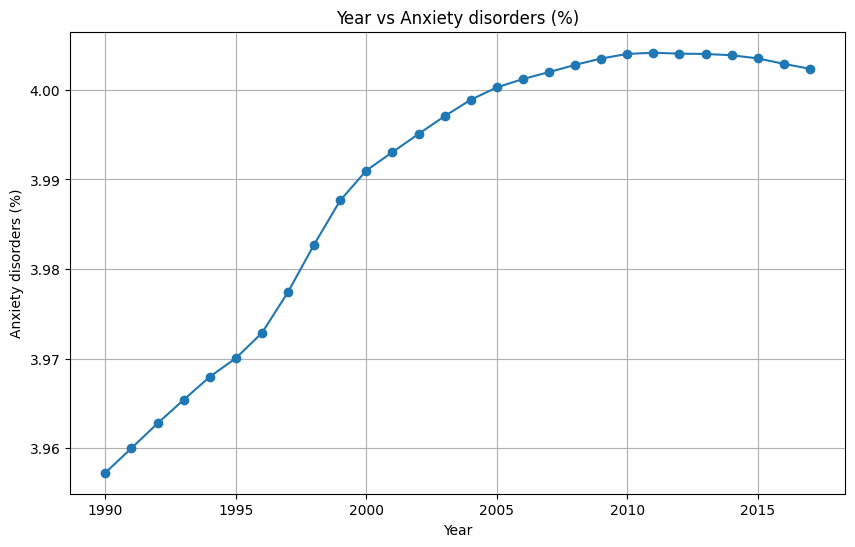

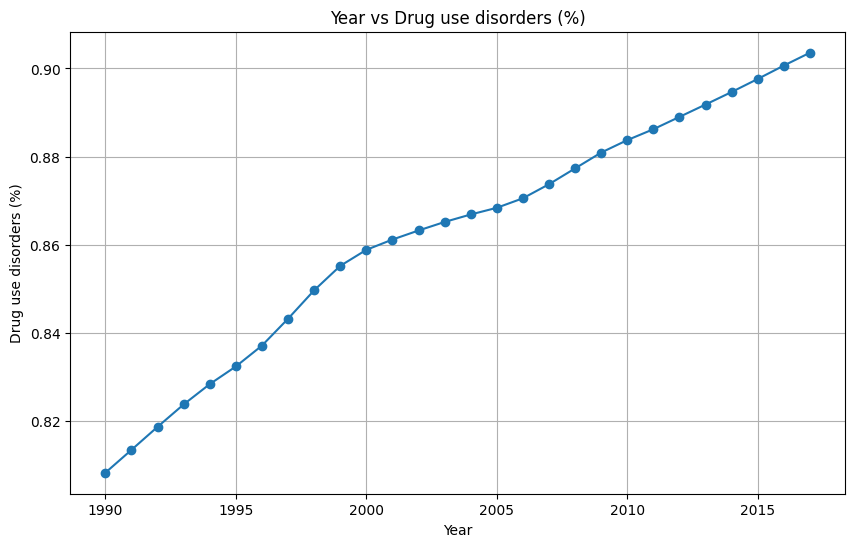

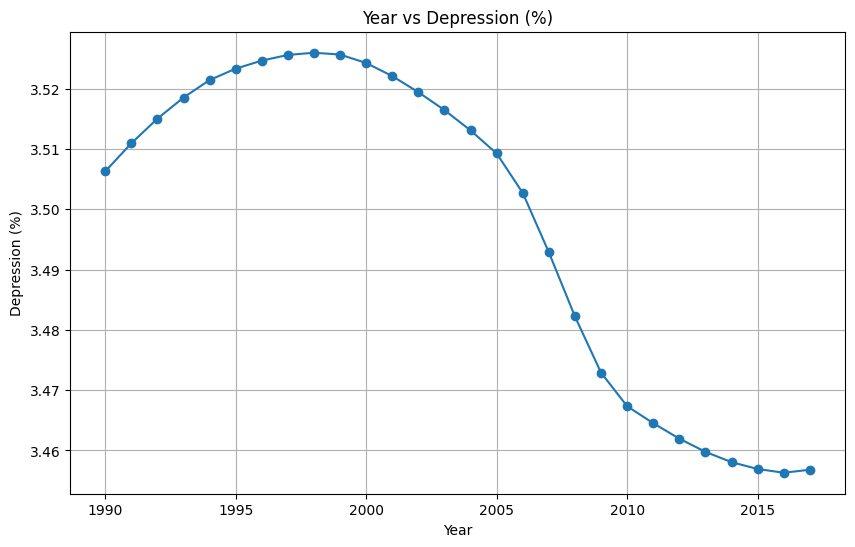

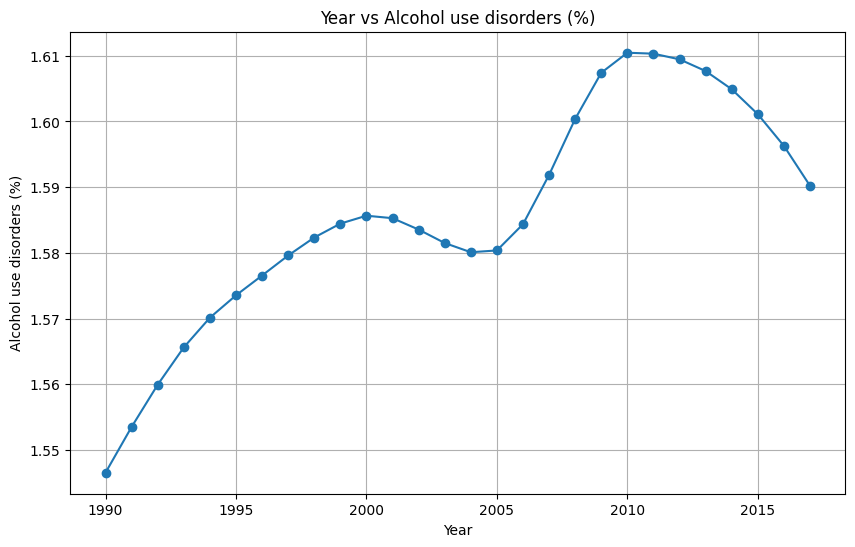

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year                       28 non-null     int32  
 1   Schizophrenia (%)          28 non-null     float64
 2   Bipolar disorder (%)       28 non-null     float64
 3   Eating disorders (%)       28 non-null     float64
 4   Anxiety disorders (%)      28 non-null     float64
 5   Drug use disorders (%)     28 non-null     float64
 6   Depression (%)             28 non-null     float64
 7   Alcohol use disorders (%)  28 non-null     float64
dtypes: float64(7), int32(1)
memory usage: 1.8 KB


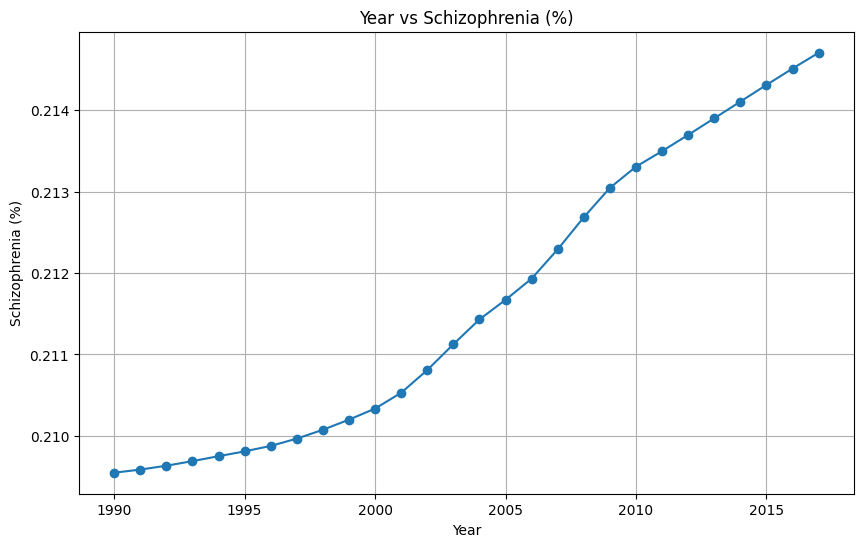

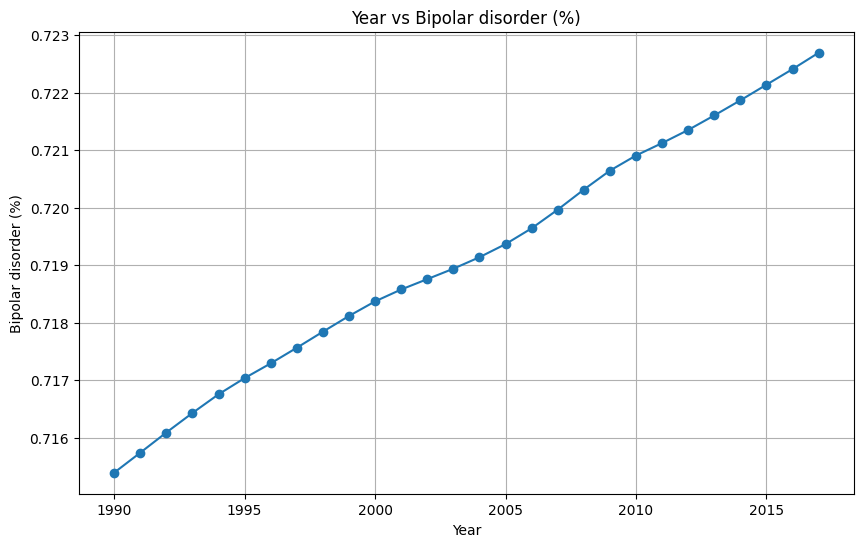

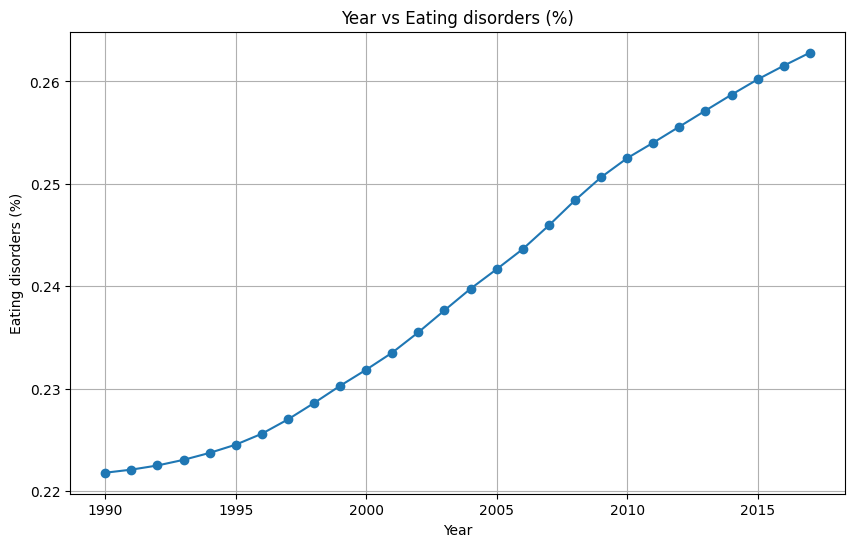

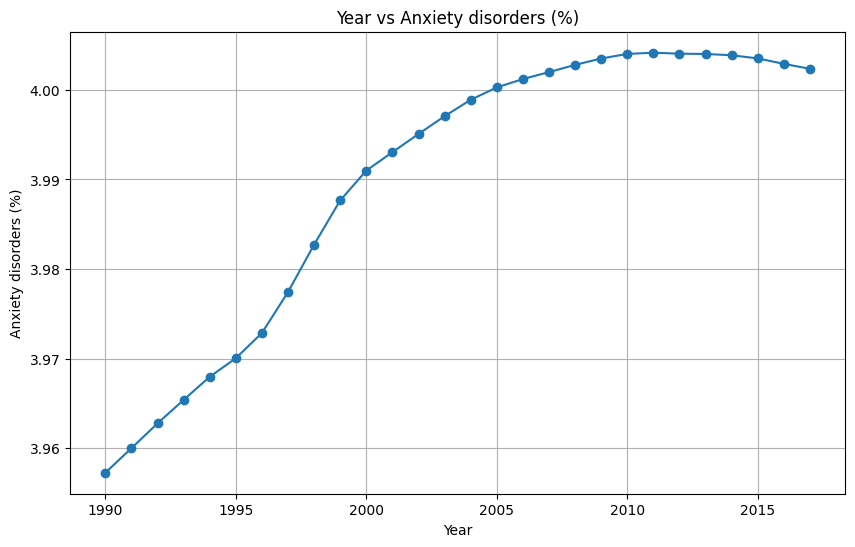

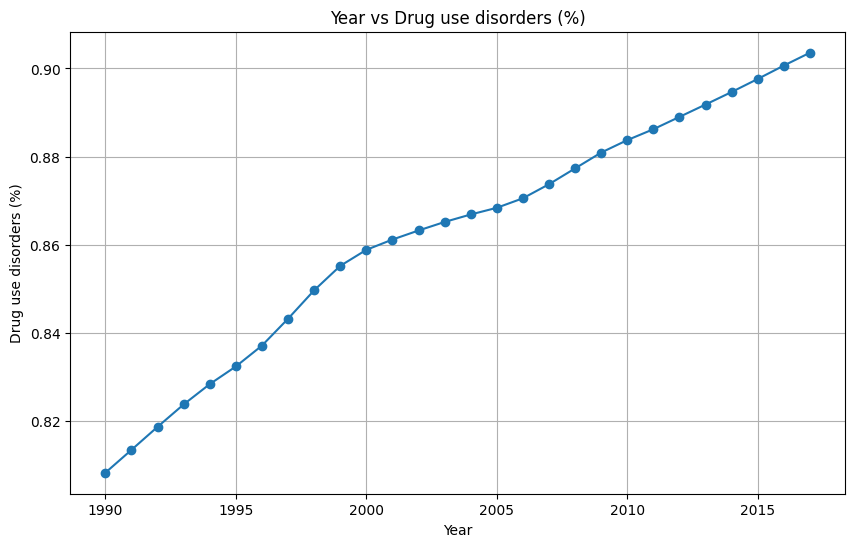

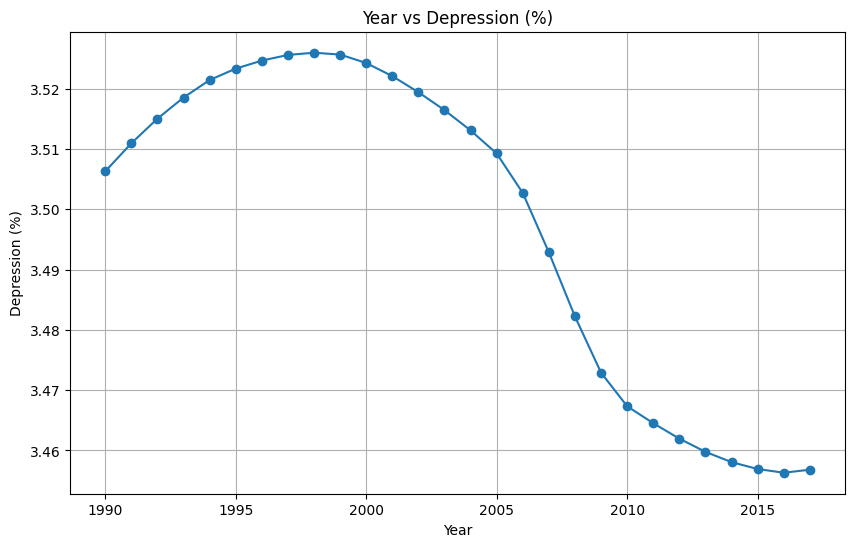

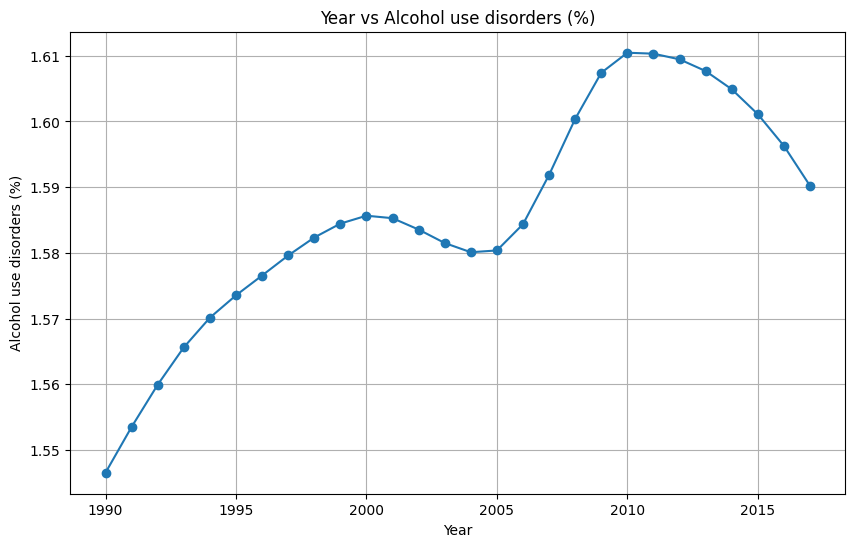

In [107]:
def visualizePattern(data, feature):
    plt.figure(figsize=(10, 6))
    plt.plot(data['Year'], data[feature], marker='o')
    plt.xlabel("Year")
    plt.ylabel(feature)
    plt.title(f'Year vs {feature}')
    plt.grid(True)
    plt.show()


for dataframe in data:
    dataframe.info()
    for feature in dataframe.columns[1:]:
        visualizePattern(dataframe, feature)


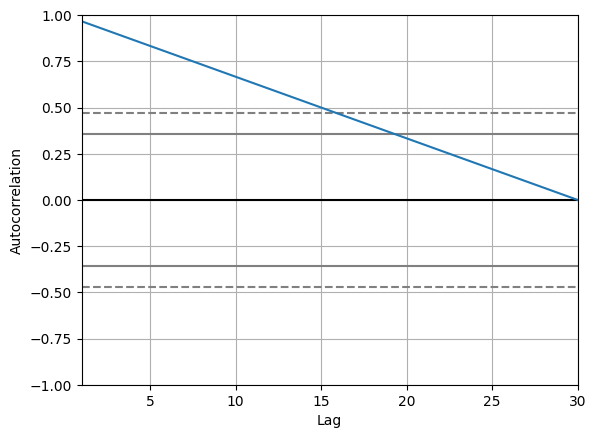

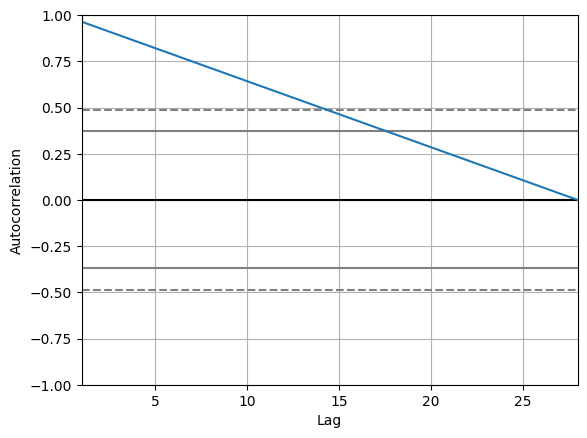

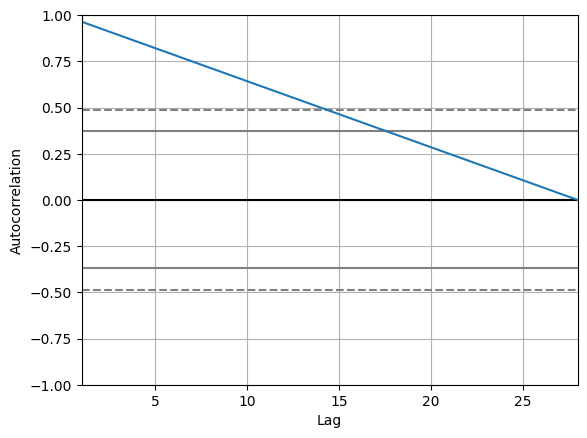

In [115]:
for dataframe in data:
    autocorrelation_plot(dataframe)
    plt.show()

In [118]:
def findDifferencingDegree(data):
    frame = data.copy()
    pValue =  adfuller(frame)[1]
    d = 0
    alpha = 0.05
    while pValue > alpha:
        frame = frame.diff().dropna() 
        d += 1
        pValue = adfuller(frame)[1]
    return d

## Forecasting

In [108]:
def movingAverage(data, window):
    return data.rolling(window=window).mean()

In [110]:
def exponentialSmoothing(data):
    model = ExponentialSmoothing(data, trend='add', seasonal=None).fit()
    return model.forecast(steps=10) 

In [111]:
def autoRegressive(data,lag):
    model = AutoReg(data, lags=lag).fit()
    return model.predict(start=len(data), end=len(data)+10)

In [119]:
def integratedAutoRegressiveMovingAverage(data,lag,window):
    d = findDifferencingDegree(data)
    model = ARIMA(data,order(lag,d,window)) 